# Testing FFNN on classification problems

In [7]:
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import itertools
import autograd.numpy as np
import pandas as pd
from tqdm import tqdm

from activation_functions import *
from cost_functions import *
from FFNN import *

# Setting the random seed
np.random.seed(42)


In [8]:

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
# Extract data (features) and target (labels)
X = mnist.data[:2500]
y = mnist.target[:2500]

# Scaling the mnist pixel values from 0-255 to 0-1
X = X / 255.0

print(X.shape)
print(y.shape)

(2500, 784)
(2500,)


In [9]:
# Splitting the data into testing, training and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

# One-hot encoding
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)
y_val = to_one_hot(y_val)

# Testing learning rates

In [10]:
network_input_size = X_train.shape[1]
layer_output_sizes = [500, 10]
activation_funcs = [sigmoid, softmax]

In [11]:
# Create initial network and save the initial layers
NN_initial = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)
initial_layers = deepcopy(NN_initial.layers)

In [12]:
epochs = 25

accs = []

etas = np.logspace(1, -4, num=6)

for eta in etas:
    NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)
    NN.layers = deepcopy(initial_layers)

    train_network_stocastic_ADAM(NN, X_train, y_train, eta=eta, epochs=epochs)

    y_pred = NN.predict(X_train)

    acc = accuracy(y_pred, y_train)

    accs.append(acc)

c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: overflow encountered in square
  lambda ans, x, y: unbroadcast_f(y, lambda g: -g * x / y**2),
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:160: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp, lambda ans, x: lambda g: ans * g)


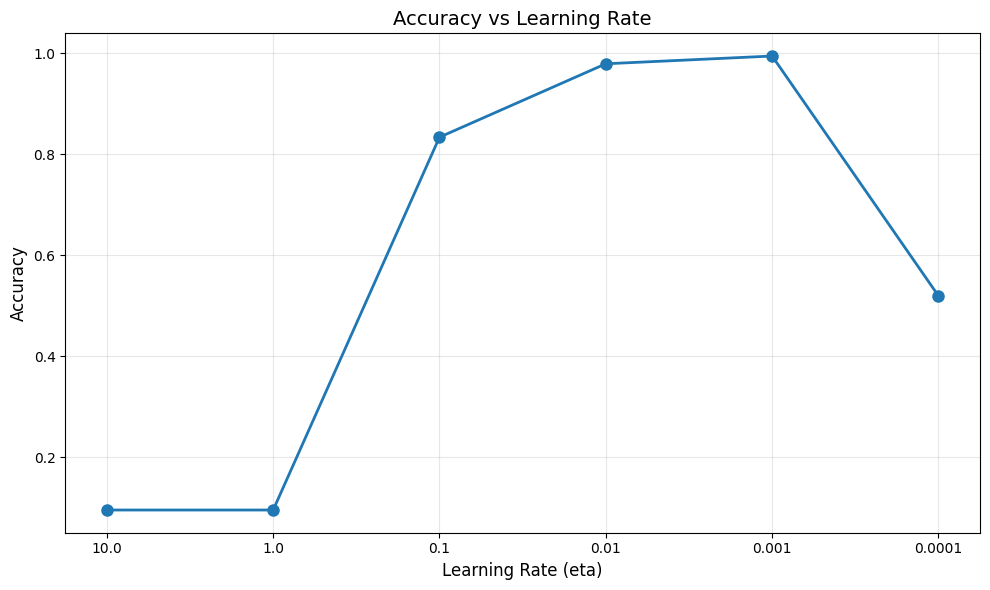

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(etas)), accs, marker='o', linewidth=2, markersize=8)
plt.xticks(range(len(etas)), etas)  # Label x-axis with eta values
plt.xlabel('Learning Rate (eta)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Learning Rate', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Testing parameter combinations with grid search

In [14]:
# Splitting the data into testing an training sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

# One-hot encoding
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)
y_val = to_one_hot(y_val)

In [15]:
# Define parameters
layer_sizes = [25, 250, 1000]
num_hidden_layers = [0, 1, 2]
etas = np.logspace(-1, -2, num=2)
activation_functions = [sigmoid, ReLU, leaky_ReLU, softmax]
epochs = [100]
optimizers = [train_network_SRMSprop, train_network_stocastic_ADAM]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]

In [16]:

total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # If no hidden layers
    if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
    else:
        # Hidden layers + output layer
        layer_output_sizes = [num_nodes] * num_layers + [10]
        activation_funcs = [act_func] * num_layers + [softmax]

    # Create and train network
    NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

    optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

    train_pred = NN.predict(X_train)
    val_pred = NN.predict(X_val)
    test_pred = NN.predict(X_test)
    
    train_accuracy = accuracy(train_pred, y_train)
    val_accuracy = accuracy(val_pred, y_val)
    test_accuracy = accuracy(test_pred, y_test)

    # Store results
    results.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_accuracy,
        'val_acc': val_accuracy,
        'test_acc': test_accuracy
    })

  2%|▏         | 3/144 [00:04<03:38,  1.55s/it]c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
 33%|███▎      | 48/144 [01:14<02:28,  1.55s/it]c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: overflow encountered in square
  

In [17]:
# Evaluate results
df_results1 = pd.DataFrame(results)

# Save results to file
df_results1.to_csv("Mnist2500_results1.csv", index=False)

# Get top 25 configurations
top_25 = df_results1.nlargest(25, 'val_acc').copy()
top_25


,n_hidden,layer_size,eta,activation,n_epochs,optimizer,train_acc,val_acc,test_acc
72,1,250,0.01,sigmoid,100,train_network_SRMSprop,0.999333,0.920,0.910
73,1,250,0.01,sigmoid,100,train_network_stocastic_ADAM,0.996667,0.912,0.908
88,1,1000,0.01,sigmoid,100,train_network_SRMSprop,0.994000,0.906,0.914
120,2,250,0.01,sigmoid,100,train_network_SRMSprop,0.988000,0.906,0.894
136,2,1000,0.01,sigmoid,100,train_network_SRMSprop,0.972667,0.904,0.866
121,2,250,0.01,sigmoid,100,train_network_stocastic_ADAM,0.987333,0.898,0.892
104,2,25,0.01,sigmoid,100,train_network_SRMSprop,0.999333,0.894,0.870
56,1,25,0.01,sigmoid,100,train_network_SRMSprop,0.999333,0.878,0.844
80,1,1000,0.10,sigmoid,100,train_network_SRMSprop,0.948667,0.874,0.814
89,1,1000,0.01,sigmoid,100,train_network_stocastic_ADAM,0.994667,0.874,0.896


In [18]:
# Define parameters
layer_sizes = [25, 100, 250, 500, 1000]
num_hidden_layers = [0, 1, 2, 3, 4]
etas = [0.01]
activation_functions = [sigmoid]
epochs = [5, 25, 100, 250, 500]
optimizers = [train_network_SRMSprop, train_network_stocastic_ADAM]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]

In [19]:

total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # If no hidden layers
    if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
    else:
        # Hidden layers + output layer
        layer_output_sizes = [num_nodes] * num_layers + [10]
        activation_funcs = [act_func] * num_layers + [softmax]

    # Create and train network
    NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

    optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

    train_pred = NN.predict(X_train)
    val_pred = NN.predict(X_val)
    test_pred = NN.predict(X_test)
    
    train_accuracy = accuracy(train_pred, y_train)
    val_accuracy = accuracy(val_pred, y_val)
    test_accuracy = accuracy(test_pred, y_test)

    # Store results
    results.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_accuracy,
        'val_acc': val_accuracy,
        'test_acc': test_accuracy
    })

100%|██████████| 250/250 [5:11:38<00:00, 74.79s/it]    


In [ ]:
# Evaluate results
df_results2 = pd.DataFrame(results)

# Save results to file
df_results2.to_csv("Mnist2500_results2.csv", index=False)

# Get top 25 configurations
top_25 = df_results2.nlargest(25, 'val_acc').copy()
top_25


# Testing layers and nodes

In [20]:
network_input_size = X_train.shape[1]
layer_sizes = [50, 100, 250, 500, 1000]
num_hidden_layers = [0, 1, 2, 3, 4]

In [ ]:
# Store results in 2D array
results = np.zeros((len(num_hidden_layers), len(layer_sizes)))

for i, num_layers in enumerate(num_hidden_layers):
    for j, layer_size in enumerate(layer_sizes):

        if num_layers == 0:
            # No hidden layers - just input to output
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [layer_size] * num_layers + [10]
            activation_funcs = [sigmoid] * num_layers + [softmax]


        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

        train_network_stocastic_ADAM(NN, X_train, y_train, eta=0.01, epochs=250)
        
        y_pred = NN.predict(X_test)
        acc = accuracy(y_pred, y_test)

        results[i, j] = acc

        print(f"Done with: {num_layers} x {layer_size} -- acc = {acc}")


plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=num_hidden_layers,
            yticklabels=layer_sizes,
            cbar_kws={'label': 'Accuracy'})
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Nodes per Hidden Layer')
plt.title('Test Accuracy Heatmap - Sigmoid')
plt.show()

Done with: 0 x 50 -- acc = 0.86
Done with: 0 x 100 -- acc = 0.836
Done with: 0 x 250 -- acc = 0.818
Done with: 0 x 500 -- acc = 0.81
Done with: 0 x 1000 -- acc = 0.824
Done with: 1 x 50 -- acc = 0.88
Done with: 1 x 100 -- acc = 0.888


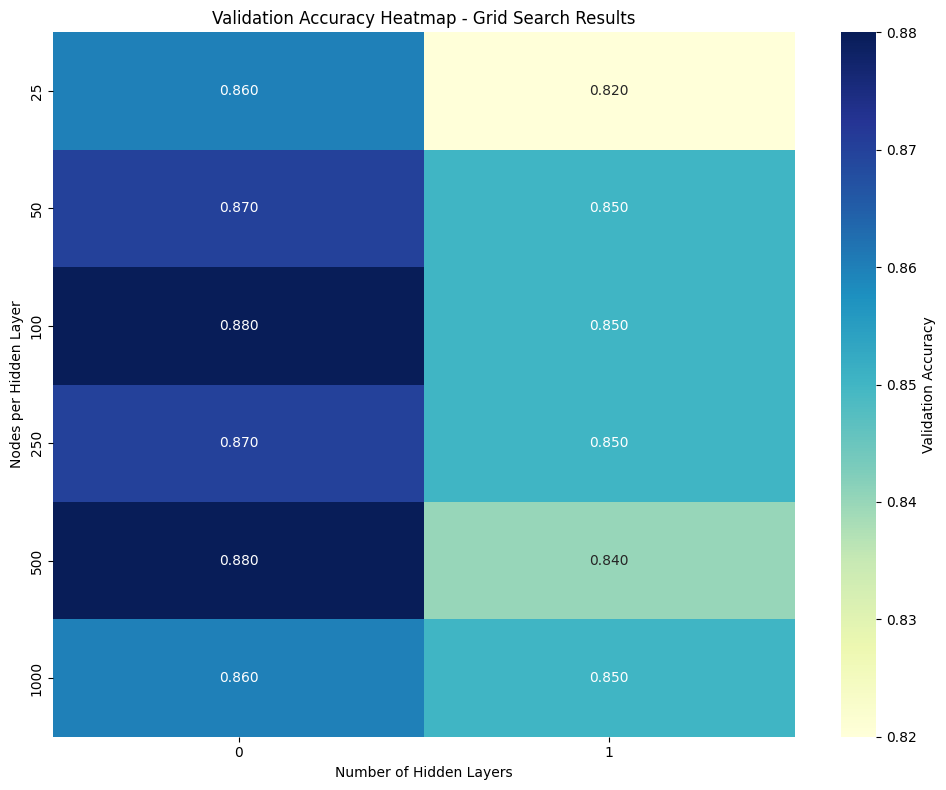

In [ ]:
# Load the results from CSV
df_results = pd.read_csv("Mnist2500_results.csv")

# Get unique values for the axes
num_hidden_layers = sorted(df_results['n_hidden'].unique())
layer_sizes = sorted(df_results['layer_size'].unique())

# Create 2D array for heatmap
results = np.zeros((len(layer_sizes), len(num_hidden_layers)))

# Fill the results array with validation accuracy
for i, layer_size in enumerate(layer_sizes):
    for j, num_layers in enumerate(num_hidden_layers):
        # Filter for this specific combination
        mask = (df_results['n_hidden'] == num_layers) & (df_results['layer_size'] == layer_size)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results[mask]['val_acc'].max()
        else:
            results[i, j] = np.nan

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=num_hidden_layers,
            yticklabels=layer_sizes,
            cbar_kws={'label': 'Validation Accuracy'})
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Nodes per Hidden Layer')
plt.title('Validation Accuracy Heatmap - Grid Search Results')
plt.tight_layout()
plt.show()

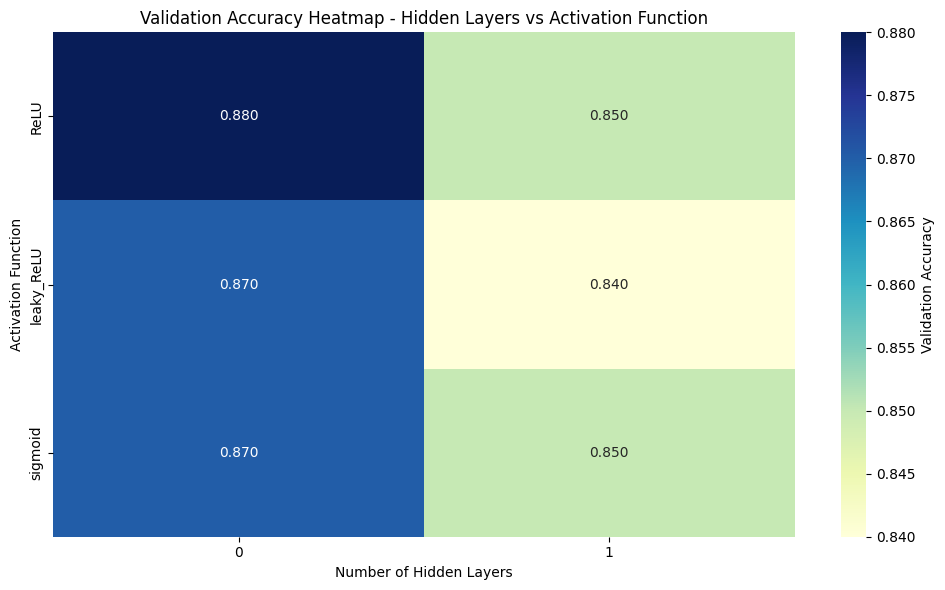

In [ ]:
# Load the results from CSV
df_results = pd.read_csv("Mnist2500_results.csv")

# Get unique values for the axes
num_hidden_layers = sorted(df_results['n_hidden'].unique())
activation_functions = sorted(df_results['activation'].unique())

# Create 2D array for heatmap
results = np.zeros((len(activation_functions), len(num_hidden_layers)))

# Fill the results array with validation accuracy
for i, activation in enumerate(activation_functions):
    for j, num_layers in enumerate(num_hidden_layers):
        # Filter for this specific combination
        mask = (df_results['n_hidden'] == num_layers) & (df_results['activation'] == activation)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results[mask]['val_acc'].max()
        else:
            results[i, j] = np.nan

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=num_hidden_layers,
            yticklabels=activation_functions,
            cbar_kws={'label': 'Validation Accuracy'})
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Activation Function')
plt.title('Validation Accuracy Heatmap - Hidden Layers vs Activation Function')
plt.tight_layout()
plt.show()

In [ ]:
# Store results in 2D array
results = np.zeros((len(num_hidden_layers), len(layer_sizes)))

for i, num_layers in enumerate(num_hidden_layers):
    for j, layer_size in enumerate(layer_sizes):

        if num_layers == 0:
            # No hidden layers - just input to output
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [layer_size] * num_layers + [10]
            activation_funcs = [leaky_ReLU] * num_layers + [softmax]


        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

        train_network_stocastic_ADAM(NN, X_train, y_train_onehot, eta=0.01, epochs=250)
        
        y_pred = NN.predict(X_test)
        acc = accuracy(y_pred, y_test_onehot)

        results[i, j] = acc

        print(f"Done with: {num_layers} x {layer_size} -- acc = {acc}")

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=num_hidden_layers,
            yticklabels=layer_sizes,
            cbar_kws={'label': 'Accuracy'})
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Nodes per Hidden Layer')
plt.title('Test Accuracy Heatmap - Leaky ReLU')
plt.show()

Done with: 0 x 50 -- acc = 0.14
Done with: 0 x 100 -- acc = 0.12
Done with: 0 x 250 -- acc = 0.12
Done with: 0 x 500 -- acc = 0.12
Done with: 0 x 1000 -- acc = 0.12
Done with: 1 x 50 -- acc = 0.12


KeyboardInterrupt: 

Done with: 0 x 50
Done with: 0 x 100
Done with: 0 x 250
Done with: 0 x 500
Done with: 0 x 1000
Done with: 1 x 50
Done with: 1 x 100
Done with: 1 x 250
Done with: 1 x 500
Done with: 1 x 1000
Done with: 2 x 50
Done with: 2 x 100
Done with: 2 x 250


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)


Done with: 2 x 500


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Datapro

Done with: 2 x 1000
Done with: 3 x 50


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)


Done with: 3 x 100


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: overflow encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessi

Done with: 3 x 250


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\P

Done with: 3 x 500


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\P

Done with: 3 x 1000


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Datapro

Done with: 4 x 50


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\P

Done with: 4 x 100


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\P

Done with: 4 x 250


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\P

Done with: 4 x 500


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\P

Done with: 4 x 1000


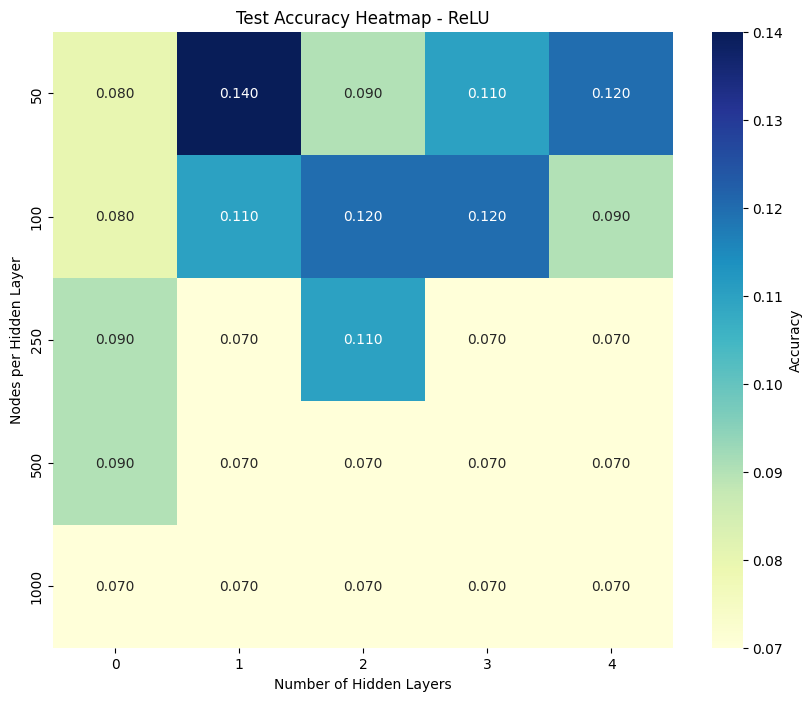

In [ ]:
# Store results in 2D array
results = np.zeros((len(num_hidden_layers), len(layer_sizes)))

for i, num_layers in enumerate(num_hidden_layers):
    for j, layer_size in enumerate(layer_sizes):

        if num_layers == 0:
            # No hidden layers - just input to output
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [layer_size] * num_layers + [10]
            activation_funcs = [ReLU] * num_layers + [softmax]


        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

        train_network_stocastic_ADAM(NN, X_train, y_train_onehot, eta=0.01, epochs=250)
        
        y_pred = NN.predict(X_test)
        acc = accuracy(y_pred, y_test_onehot)

        results[i, j] = acc

        print(f"Done with: {num_layers} x {layer_size} -- acc = {acc}")

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=num_hidden_layers,
            yticklabels=layer_sizes,
            cbar_kws={'label': 'Accuracy'})
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Nodes per Hidden Layer')
plt.title('Test Accuracy Heatmap - ReLU')
plt.show()